# In-class exercise 1: Discover Sentinel 1 data using the EODC STAC catalog

This notebook demonstrates how to access radar data in a SpatioTemporal Asset Catalog (STAC) Catalogue using the pystac library. In this example, we use Sentinel-1 data from the EODC (earth observation data and high performance computing service provider based in Vienna) STAC catalog. In the further process, we will learn how to query a STAC catalog, select specific items, and display the metadata and the actual image.

In [1]:
import pystac_client
import folium
from odc import stac as odc_stac

In [2]:
eodc_catalog = pystac_client.Client.open(
    "https://stac.eodc.eu/api/v1"
    )

eodc_catalog

<Client id=stac-fastapi>

The URL https://stac.eodc.eu/api/v1, served over Hypertext Transfer Protocol (HTTP), is a STAC-compliant API endpoint (specific URL address where an API service is available) that leads to the EODC Catalogue. Besides EODC's, other catalogues can be found on [STAC Index](https://stacindex.org/catalogs), such as United States Geological Survey (USGS) Landsat imagery, Sentinel Hub, Copernicus Data Space Ecosystem, and so on. Briefly spoken, STAC can be used to search, discover, and access metadata of these datasets with the same code. The EODC Catalogue can be accessed on the web via this [link](https://services.eodc.eu/browser/#/?.language=en) as well.

Each STAC catalog, composed by different providers, has many collections. To get all collections of a catalog, we can print all of them and their ids, which are used to fetch them from the catalog. 

In [3]:
collections = eodc_catalog.get_collections()

# length of string of collection.id, for pretty print
max_length = max(len(collection.id) for collection in collections)

for collection in eodc_catalog.get_collections():
    print(f"{collection.id.ljust(max_length)} : {collection.title}")

SENTINEL2_L2A                     : Sentinel-2 MSI Products: Level-2A data
SENTINEL2_GRI_L1C                 : Multi-Layer Copernicus Sentinel-2 GRI in L1C
DOP_AUT_K_OSTTIROL                : Digital Orthophotos (DOP) Austria - Land Kärnten: Orthofotos Flugblock Osttirol
SENTINEL1_HPAR                    : SENTINEL1 Harmonic Parameters
AUT_DEM                           : Austrian High Resolution DEM
COP_DEM                           : Copernicus Digital Elevation Model (DEM)
DOP_AUT_K_KLAGENFURT              : Digital Orthophotos (DOP) Austria - Land Kärnten: Orthofotos Flugblock Klagenfurt
DOP_AUT_K_WOLFSBERG               : Digital Orthophotos (DOP) Austria - Land Kärnten: Orthofotos Flugblock Wolfsberg
SENTINEL1_MPLIA                   : SENTINEL1 Mean PLIA
SENTINEL1_SLC                     : Sentinel-1 SLC
SENTINEL1_GRD                     : Sentinel-1 SAR L1 GRD
AI4SAR_SIG0                       : AI4SAR Despeckled Sentinel-1 Sigma0 (20m)
SENTINEL3_SRAL_L2                 : Sentin

To get a specific collection from the catalog, we can use the `client.get_collection()` method and provide the collection name. We can then display its description, id, temporal and spatial extent, license, etc. In this notebook, we will work with the Sentinel-1 SIG0 20m collection.

In [4]:
colllection_id = 'SENTINEL1_SIG0_20M'

collection = eodc_catalog.get_collection(colllection_id)
collection

<CollectionClient id=SENTINEL1_SIG0_20M>

Each collection has multiple items. An item is one spatio-temporal instance the collection, for instance a satellite image. If items are needed for a specific timeframe or for a specific region of interest, we can define this as a query.

In [5]:
time_range = "2022-10-01/2022-10-07"  # a closed range
# time_range = "2022-01"  # whole month, same can be done for a year and a day
# time_range = "2022-01-01/.."  # up to the current date, an open range
# time_range = "2022-01-01T05:34:46"  # a specific time instance

A spatial region of interest can be defined in different ways. One option is to define a simple bounding box:

In [6]:
latmin, latmax = 46.3, 49.3  # South to North
lonmin, lonmax = 13.8, 17.8  # West to East

bounding_box = [lonmin, latmin, lonmax, latmax]

If the region of interest is not rectengular, we can also define a polygon:

In [7]:
# GEOJSON can be created on geojson.io

# This specific area of interest is a rectangle, but since it is
# a closed polygon it seems like it has five nodes

area_of_interest = {
    "coordinates": [
          [
            [
              17.710928010825853,
              49.257630084442496
            ],
            [
              13.881798300915221,
              49.257630084442496
            ],
            [
              13.881798300915221,
              46.34747715326259
            ],
            [
              17.710928010825853,
              46.34747715326259
            ],
            [
              17.710928010825853,
              49.257630084442496
            ]
          ]
        ],
        "type": "Polygon"
        }

Using our previously loaded STAC catalog, we can now search for items fullfilling our query. In this example we are using the bounding box. If we want to use an area of interest specified in the geojson format - one hast to use the intersects parameter as documented in the comment below.

In [8]:
search = eodc_catalog.search(
    collections=colllection_id,  # can also be a list of several collections
    bbox=bounding_box,  # search by bounding box
    # intersects=area_of_interest,  # GeoJSON search
    datetime=time_range,
    # max_items = 1  # number of max items to load
    )

# If we comment everything besides colllection_id, we will load whole
# collection for available region and time_range

items_eodc = search.item_collection()
print(f"On EODC we found {len(items_eodc)} items for the given search query")

On EODC we found 52 items for the given search query


Now, we can fetch a single item, in this case a Sentinel-1 image, from the query results. A good practice is to always check what metadata the data provider has stored on the item level. This can be done by looking into the item properties.

In [9]:
item = items_eodc[0]
item.properties

{'gsd': 20,
 'parent': 'S1A_IW_GRDH_1SDV_20221007T170811_20221007T170836_045339_056BBA_D830.zip',
 'checksum': '576abe68a715e5ee177d8b640871e873',
 'datetime': '2022-10-07T17:08:11Z',
 'blocksize': {'x': 15000, 'y': 5},
 'proj:bbox': [4800000, 1500000, 5100000, 1800000],
 'proj:wkt2': 'PROJCS["Azimuthal_Equidistant",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]],PROJECTION["Azimuthal_Equidistant"],PARAMETER["latitude_of_center",53],PARAMETER["longitude_of_center",24],PARAMETER["false_easting",5837287.81977],PARAMETER["false_northing",2121415.69617],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]',
 'proj:shape': [15000, 15000],
 'Equi7_TileID': 'EU020M_E048N015T3',
 'constellation': 'sentinel-1',
 'proj:geometry': {'type': 'Polygon',
  'coordinates': [[[4800000.0, 1500000.0],
    [4800000.0, 1800000.0],
    [5100000.0, 1800000.0],
   

For now, let's display only the vertical-vertical (VV) polarized band of the item and some information about the data.

In [10]:
item.assets['VV'].extra_fields.get('raster:bands')[0]

{'scale': 10,
 'nodata': -9999,
 'offset': 0,
 'data_type': 'int16',
 'spatial_resolution': 20}

In the EODC STAC catalogue an item can conveniently be displayed using its thumbnail.

In [11]:
item.assets['thumbnail'].href

'https://data.eodc.eu/collections/SENTINEL1_SIG0_20M/V1M1R1/EQUI7_EU020M/E048N015T3/SIG0_20221007T170811__VV_A117_E048N015T3_EU020M_V1M1R1_S1AIWGRDH_TUWIEN.tif/thumbnail'

Now we will plot the data on a map using the thumbnail and the python package [folium](https://python-visualization.github.io/folium/latest/user_guide.html). This is an easy way to quickly check how the data found by a search query looks on a map.

In [12]:
map = folium.Map(location=[(latmin+latmax)/2, (lonmin+lonmax)/2],
                 zoom_start=7,
                 zoom_control=False,
                 scrollWheelZoom=False,
                 dragging=False)

folium.GeoJson(area_of_interest, name="Area of Interest").add_to(map)

for item in items_eodc:
    # url leading to display of an item, can also be used as hyperlink
    image_url = item.assets['thumbnail'].href
    bounds = item.bbox
    folium.raster_layers.ImageOverlay(
        image=image_url,
        bounds=[[bounds[1], bounds[0]],
                [bounds[3], bounds[2]]],  # bounds of item
                ).add_to(map)

folium.LayerControl().add_to(map)

map

## Data Reading

STAC can also be a useful tool for the discovery of data, however it only loads metadata. This saves memory, but if one would like to do further analysis, the data has to be loaded into memory or downloaded on disk.

In the following, we will demonstrate this with the library `odc-stac`.


In [13]:
bands = ("VV") #For vertical-horizontal poalrized data, replace here "VV" with "VH" 
crs = "EPSG:27704"  # Coordinate Reference System: EQUI7 Grid of Europe
res = 20  # 20 meter

sig0_ds = odc_stac.load(items_eodc,
                        bands=bands,
                        crs=crs,
                        chunks={'time': 1,
                                'latitude': 1000,
                                'longitude': 1000},
                        resolution=res,
                        bbox=bounding_box
                        )

Let's have a look at the VV poalarized band of the dataset.

In [14]:
sig0_ds.VV

<xarray.DataArray 'VV' (time: 31, y: 18269, x: 16725)> Size: 19GB
dask.array<VV, shape=(31, 18269, 16725), dtype=int16, chunksize=(1, 18269, 16725), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 146kB 1.762e+06 1.762e+06 ... 1.396e+06 1.396e+06
  * x            (x) float64 134kB 5.052e+06 5.052e+06 ... 5.387e+06 5.387e+06
    spatial_ref  int32 4B 27704
  * time         (time) datetime64[ns] 248B 2022-10-01T05:09:56 ... 2022-10-0...
Attributes:
    nodata:   -9999

As we can see, the data is stored as a `xarray` DataArray. `Xarray` is a convenient package for multidimensional labeled arrays, like temperature, humidity, pressure, different bands of satellite imagery, and so on. [The link](https://docs.xarray.dev/en/stable/index.html) provides detailed documentation. In a later notebook we will explore some more of the functionality of `xarray`. As we can see in the coordinates, the data here consists of 21 time steps. 

In general, data from STAC is "lazily" loaded, which means that the structure of the DataArray is constructed, but the data is not loaded yet. It is loaded only at instance when it is needed, for example, for plotting, computations, and so on.

Since the DataArray has currently a size of almost 18 GiB, we will subset it to the region of Vienna.

In [15]:
# Create a bounding box covering the region of Vienna
latmin_smaller, latmax_smaller = 48, 48.4
lonmin_smaller, lonmax_smaller = 16, 16.5

smaller_bounding_box = [[latmin_smaller, lonmin_smaller],
                        [latmax_smaller, lonmax_smaller]]

map = folium.Map(location=[(latmin_smaller+latmax_smaller)/2,
                           (lonmin_smaller+lonmax_smaller)/2],
                           zoom_start=8,
                 zoom_control=False,
                 scrollWheelZoom=False,
                 dragging=False)

folium.GeoJson(area_of_interest, name="Area of Interest").add_to(map)

folium.Rectangle(
    bounds=smaller_bounding_box,
    color="red",
    ).add_to(map)

for item in items_eodc:
    image_url = item.assets['thumbnail'].href
    bounds = item.bbox
    folium.raster_layers.ImageOverlay(
        image=image_url,
        bounds=[[bounds[1], bounds[0]], [bounds[3], bounds[2]]],
        ).add_to(map)

folium.LayerControl().add_to(map)

map

In [16]:
# Create a new dataset with the smaller bounding box covering the region of Vienna
sig0_ds = odc_stac.load(items_eodc,
                        bands=bands,
                        crs=crs,
                        chunks={'time': 1,
                                'latitude': 1000,
                                'longitude': 1000},
                        resolution=res,
                        bbox=[lonmin_smaller, latmin_smaller,
                              lonmax_smaller, latmax_smaller],
                        # groupby='time'
                        )

Due to the way the data is acquired and stored, some items include "no data" areas. In our case, no data has the value -9999, but this can vary from data provider to data provider. This information can usually be found in the metadata. Furthermore, to save memory, data is often stored as integer (e.g. 25) and not in float (e.g. 2.5) format. For this reason, the backscatter values are often multiplied by a scale factor, in this case factor 10.

As Sentinel-1 satellites overpasses Austria every few days, only some time steps of the dataset will have physical data. As a final step, we will now decode the data and create a plot of two consecutive Sentinel-1 acquisitions of Vienna.

In [17]:
# Retrieve the scale factor and NoData value from the metadata. raster:bands is a STAC raster extension.
scale = item.assets['VV'].extra_fields.get('raster:bands')[0]['scale']
nodata = item.assets['VV'].extra_fields.get('raster:bands')[0]['nodata']

# Decode data with the NoData value and the scale factor
sig0_ds = sig0_ds.where(sig0_ds!=nodata) / scale

# We should remove unnecessary dates when there was no data
# (no satellite overpass)
sig0_ds = sig0_ds.dropna(dim='time')

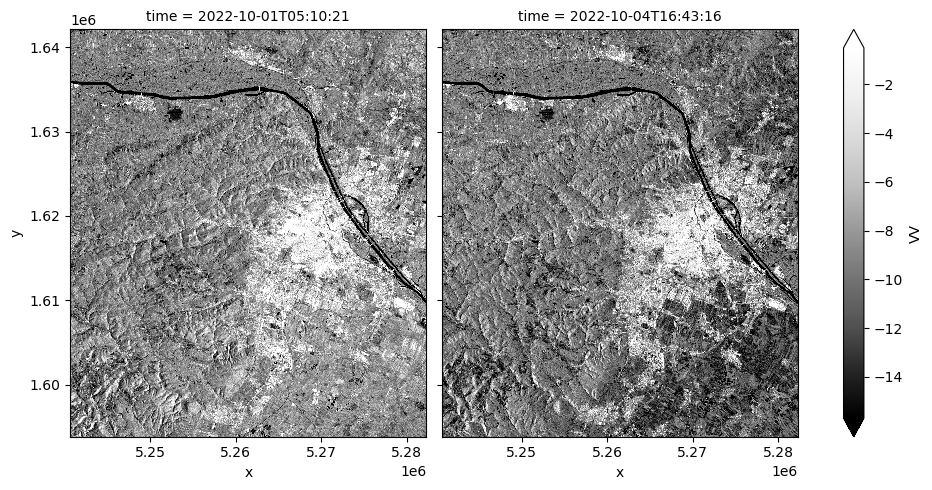

In [18]:
sig0_ds.VV.plot(col='time', col_wrap=2, robust=True, figsize=(10, 5), cmap='Greys_r')